In [17]:
from model import Densenet, Inceptionv3, ResNet, VGG, SimpleCNN, Efficientnet, ResNeSt, Ensemble,SeResNet, Deeplabv3
from model import prunnableResNet
from model.layer.prunableLayer import prunnableConv2D,prunnableLinear
from utils import CovidCTDataset,metrics, SimCLR_loss, LabelSmoothSoftmaxCE
from utils import autoaugment as auto
from torch.utils.data import DataLoader
import argparse
import torch
import torch.nn.functional as F
from tqdm import tqdm
import time
import torch.nn as nn
import os
import random
from torchvision import transforms
import numpy as np
from sklearn.metrics import roc_auc_score

from collections import OrderedDict
import matplotlib.pyplot as plt
import easydict

import gc

MODEL_DICT = {
    'densenet121': Densenet.densenet121,
    'densenet161': Densenet.densenet161,
    'densenet169': Densenet.densenet169,
    'densenet201': Densenet.densenet201,
    'resnet18': ResNet.resnet18,
    'resnet50': ResNet.resnet50,
    'resnet101': ResNet.resnet101,
    'resnet152': ResNet.resnet152,
    'seresnet50': SeResNet.se_resnet50,
    'seresnet101': SeResNet.se_resnet101,
    'seresnet152': SeResNet.se_resnet152,
    'resnext101': ResNet.resnext101_32x8d,
    'resnest50': ResNeSt.resnest50,
    'resnest200': ResNeSt.resnest200,
    'wide_resnet101': ResNet.wide_resnet101_2,
    'wide_resnet50': ResNet.wide_resnet50_2,
    'vgg16': VGG.vgg16,
    'CNN': SimpleCNN.CNN,
    'Linear': SimpleCNN.Linear,
    'SimpleCNN': SimpleCNN.SimpleCNN,
    'efficientnet-b7': Efficientnet.efficientnetb7,
    'efficientnet-b1': Efficientnet.efficientnetb1,
    'efficientnet-b0': Efficientnet.efficientnetb0
}

PRUNNABLE_MODEL_DICT={
    'resnet18':prunnableResNet.resnet18,
    'resnet50':prunnableResNet.resnet50,
    'resnet101':prunnableResNet.resnet101,
    'resnet152':prunnableResNet.resnet152
}

def train(model, train_loader, optimizer, PRINT_INTERVAL, epoch, args, device):
    model.train()
    # LOSS_FUNC = LabelSmoothSoftmaxCE()
    LOSS_FUNC = nn.CrossEntropyLoss()
    for index, batch in enumerate(tqdm(train_loader)):
        img, label = batch['img'].to(device), batch['label'].to(device)
        output = model(img)
        optimizer.zero_grad()
        loss = LOSS_FUNC(output, label)
        loss.backward()
        optimizer.step()
        if (index + 1) % PRINT_INTERVAL == 0:
            tqdm.write('Epoch [%d/%d], Iter [%d/%d], Loss: %.4f'
                       % (epoch + 1, args.epoch, index + 1, len(train_loader), loss.item()))

def test(model, nb_classes, test_loader, device):
    model.eval()
    predlist = []
    targetlist = []
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    avg_val_loss = 0
    with torch.no_grad():
        for index, batch in enumerate(tqdm(test_loader)):
            img, label = batch['img'].to(device), batch['label'].to(device)
            output = model(img)
            _, preds = torch.max(output, 1)
            avg_val_loss += F.cross_entropy(output, label).item()/len(test_loader)
            for t, p in zip(label.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            y_score = F.softmax(output, dim=1)
            predlist = np.append(predlist, y_score.cpu().numpy()[:, 1])
            targetlist = np.append(targetlist, label.long().cpu().numpy())

    AUC = roc_auc_score(targetlist, predlist)
    print(confusion_matrix)
    precision = metrics.Precision(confusion_matrix.cpu().numpy(), nb_classes)
    recall = metrics.Recall(confusion_matrix, nb_classes)
    f1 = metrics.f1_score(precision, recall)
    acc = metrics.Acc(confusion_matrix,nb_classes)

    return AUC, precision, recall, f1, acc, avg_val_loss

def test_mask(model, nb_classes, test_loader, device):
    model.eval()
    predlist = []
    targetlist = []
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    avg_val_loss = 0
    with torch.no_grad():
        for index, batch in enumerate(tqdm(test_loader)):
            img, label = batch['img'].to(device), batch['label'].to(device)
            cls_pred, mask_pred = model(img)
            _, preds = torch.max(cls_pred, 1)

            avg_val_loss += F.cross_entropy(cls_pred, label).item()/len(test_loader)
            for t, p in zip(label.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            y_score = F.softmax(cls_pred, dim=1)
            predlist = np.append(predlist, y_score.cpu().numpy()[:, 1])
            targetlist = np.append(targetlist, label.long().cpu().numpy())

    AUC = roc_auc_score(targetlist, predlist)
    print(confusion_matrix)
    precision = metrics.Precision(confusion_matrix.cpu().numpy(), nb_classes)
    recall = metrics.Recall(confusion_matrix, nb_classes)
    f1 = metrics.f1_score(precision, recall)
    acc = metrics.Acc(confusion_matrix,nb_classes)

    return AUC, precision, recall, f1, acc, avg_val_loss

def convertPaWeights2NonP(pretrained_state_dict):
  nonpStateDict=OrderedDict()
  for k, v in pretrained_state_dict.items():
    nonpStateDict[k[7:]]=v
  return nonpStateDict

def convertStateDict2Prunnable(state_dict):
    prunedStateDict=OrderedDict()
    for k, v in state_dict.items():
        if 'conv' in k or 'downsample.0' in k:
            p=k.find('.weight')
            k=k[:p]+'.conv'+k[p:]
        elif 'fc' in k:
            p=k.find('fc')
            k=k[:p+3]+'linear.'+k[p+3:]
            

        prunedStateDict[k]=v
    return prunedStateDict

models_config = (
    # model name, model path, weight, data_parallel
    ('resnet152', 'resnet152_4_4_crop_480_b16_pretrained.pt', 1, True),
    ('resnet152', 'resnet152_4_4_crop_480_b16w1.2_pretrained.pt', 1, True),
    ('resnext101', 'resnext101_4_4_crop_480_pretrained.pt', 1, True),
    ('densenet169', 'densenet169-480-moco-soft-COVID.pt', 1, True),
    ('densenet169', 'densenet169_4_4_crop_480_b16_pretrained.pt', 1, True),
    ('densenet169', 'densenet169_soft_480_pretrained.pt', 1, True),
)

args = easydict.EasyDict({
    'model_name':'resnet50',
    'checkpoint_path':'./checkpoint/CT',
    'batch_size':16,
    'lr':1e-4,
    'epoch':50,
    'root_dir':'./COVID-CT/Images-processed',

    'train_COV':'./COVID-CT/Data-split/COVID/trainCT_COVID.txt',
    'train_NonCOV':'./COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID.txt',

    'val_COV':'./COVID-CT/Data-split/COVID/valCT_COVID.txt',
    'val_NonCOV':'./COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt',

    'test_COV':'./COVID-CT/Data-split/COVID/testCT_COVID.txt',
    'test_NonCOV':'./COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt',

    'pretrained':True,
    'save_name':'resnet50_pretrained.pt'
})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device {}".format(device))
# Create checkpoint file
save_path = os.path.join(args.checkpoint_path, args.model_name)
if os.path.exists(save_path) == False:
    os.makedirs(save_path)

normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                    std=[0.33165374, 0.33165374, 0.33165374])
test_trans = transforms.Compose(
                                [
                                transforms.Resize((480,480)),
                                transforms.ToTensor(),
                                normalize
                                ]
                            )
trainset = CovidCTDataset(root_dir=args.root_dir,
                            txt_COVID=args.train_COV,
                            txt_NonCOVID=args.train_NonCOV,
                            transform=transforms.Compose(
                                [transforms.RandomResizedCrop((480,480),scale=(0.8,1.2)),
                                    transforms.RandomHorizontalFlip(),
                                    auto.ImageNetPolicy(),
                                    transforms.ToTensor(),
                                    normalize
                                    ]
                            ))
valset = CovidCTDataset(root_dir=args.root_dir,
                        txt_COVID=args.val_COV,
                        txt_NonCOVID=args.val_NonCOV,
                            transform=test_trans
                            )

testset = CovidCTDataset(root_dir=args.root_dir,
                            txt_COVID=args.test_COV,
                            txt_NonCOVID=args.test_NonCOV,
                            transform=test_trans
                            )

train_loader = DataLoader(trainset,
                            batch_size=args.batch_size,
                            num_workers=8,
                            shuffle=True)
val_loader = DataLoader(valset, batch_size=args.batch_size)
test_loader = DataLoader(testset,batch_size=args.batch_size)

PRINT_INTERVAL = 10
nb_classes = 2
seg_num_class = 2
print(args.model_name,trainset.classes)

model = PRUNNABLE_MODEL_DICT[args.model_name](num_classes=nb_classes, pretrained=args.pretrained)

accs = []
save = os.path.join(save_path,'{}'.format(args.save_name))

print('...........Testing..........')
pretrained_state_dict=torch.load(save, map_location=torch.device('cpu'))
pretrained_state_dict=convertPaWeights2NonP(pretrained_state_dict)
model.load_state_dict(convertStateDict2Prunnable(pretrained_state_dict))

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model).to(device)
elif torch.cuda.device_count() == 1:
    model.to(device)
elif torch.cuda.is_available():
    print("GPU detected but cannot use")


Device cpu
resnet50 ['CT_COVID', 'CT_NonCOVID']
...........Testing..........


In [18]:
cntConv=0
cntDense=0

for m in model.modules():
    if isinstance(m, prunnableConv2D):
        cntConv+=1
    elif isinstance(m, prunnableLinear):
        cntDense+=1
print("In total %d conv, %d dense"%(cntConv,cntDense))

In total 53 conv, 1 dense


In [19]:

ratios=[i/100 for i in range(0,91,10)]
yconvACC,yconvFN=[],[]
ydenseACC,ydenseFN=[],[]
cntConv=-1
for m in model.modules():
    yACC=[]
    yFN=[]
    if isinstance(m, (prunnableConv2D,prunnableLinear)):
        if isinstance(m,prunnableConv2D):
            cntConv+=1
            if cntConv%10!=0:continue
        print(m) 
        for r in ratios:
            m.setPruneRatio(r)
            print('prune ratio:%f'%r)
            AUC, precision, recall, f1, acc, mean_loss = test(model, 2, test_loader, device)
            print('Precision {}\tRecall {}\nF1 {}\nAUC {}\tAcc {}\tMean Loss {}'.format(precision, recall, f1, AUC, acc,
                                                                            mean_loss))
            yACC.append(acc.numpy().tolist())
            yFN.append(recall[1])
            m.resetPruneRatio()
    if isinstance(m,prunnableConv2D):
        yconvACC.append(yACC.copy())
        yconvFN.append(yFN.copy())
    elif isinstance(m,prunnableLinear):
        ydenseACC.append(yACC.copy())
        ydenseFN.append(yFN.copy())

0%|          | 0/13 [00:00<?, ?it/s]prunnableConv2D(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
)
prune ratio:0.000000
  0%|          | 0/13 [00:00<?, ?it/s]


AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [20]:
np.save('yconvACC.npy', yconvACC)
np.save('yconvFN.npy', yconvFN)
np.save('ydenseACC.npy', ydenseACC)
np.save('ydenseFN.npy', ydenseFN)
yconvACC_bak,yconvFN_bak=yconvACC.copy(),yconvFN.copy()
ydenseACC_bak,ydenseFN_bak=ydenseACC.copy(),ydenseFN.copy()

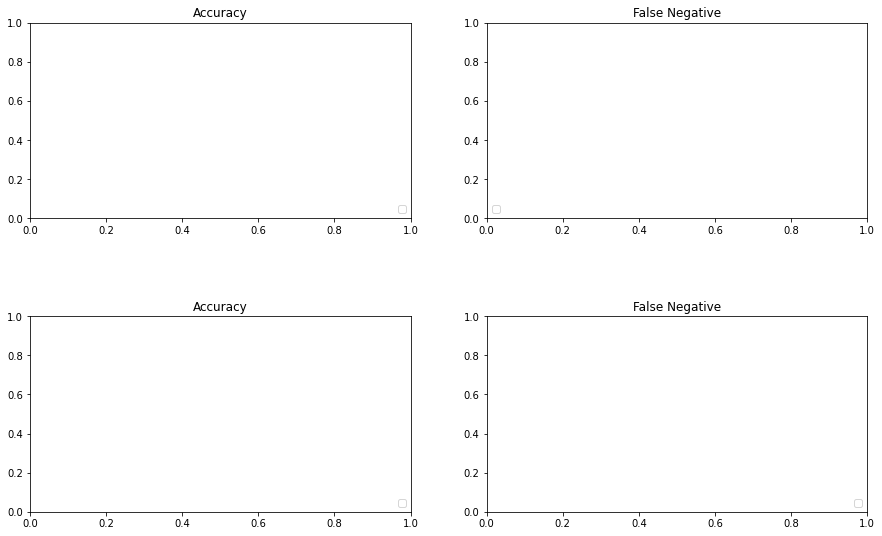

In [21]:

yconvACC,yconvFN=np.load('yconvACC.npy'),np.load('yconvFN.npy')
ydenseACC,ydenseFN=np.load('ydenseACC.npy'),np.load('ydenseFN.npy')

plt.figure(figsize=(15,9))
plt.subplots_adjust(hspace=0.5)

plt.subplot(2,2,1)
for yACC in yconvACC:
    plt.plot(ratios, yACC)
plt.title("Accuracy")
plt.legend(["conv"+str(i*10+1) for i in range(5)], loc='lower right')
plt.subplot(2,2,2)
for yFN in yconvFN:
    plt.plot(ratios, yFN)
plt.title("False Negative")
plt.legend(["conv"+str(i*10+1) for i in range(5)], loc='lower left')
plt.subplot(2,2,3)
for yACC in ydenseACC:
    plt.plot(ratios,yACC)
plt.title("Accuracy")
plt.legend(["dense"], loc='lower right')
plt.subplot(2,2,4)
for yFN in ydenseFN:
    plt.plot(ratios,yFN)
plt.title("False Negative")
plt.legend(["dense"], loc='lower right')


plt.show()

# plt.show()